#### Configuración Inicial del Entorno

Configura la GPU en caso aplique y carga las librerias necesarias para el Notebook:
- **GPU/CPU**: Configura el dispositivo (GPU por defecto). En caso no se cuente con tarjeta grafica NVIDIA, debe reemplazar gpu_num = ""
- **Sionna**: Libreria NVIDIA para simulacion de capa fisica de comunicaciones
- **TensorFlow**: Backend para Sionna, permite aceleración GPU (XLA)

Incluye codigo para auto instalacion de Sionna en Google Colab y configuracion de TensorFlow para que no arroje log de warning (economia de espacio)

In [1]:
# Importa los modulos Python necesarios

# Configura GPU, da opcion de usar CPU
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importa Sionna
# Si ejecuta localmente, no olvide instalar Sionna con "pip install sionna"
# Si ejecuta en Google Colab se instala automaticamente, ejecutar celda dos veces
try:
    import sionna
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Importa TensorFlow
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

# Importa otros modulos necesarios
import numpy as np
import pandas as pd
from datetime import datetime
import gc as gc

# Configura Matplotlib para graficos dentro del cuaderno
%matplotlib inline
import matplotlib.pyplot as plt

2026-01-30 22:09:05.235742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769828945.244760   12377 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769828945.247301   12377 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769828945.254255   12377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769828945.254266   12377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769828945.254267   12377 computation_placer.cc:177] computation placer alr

#### Parámetros de Simulación

Define los parámetros críticos del Notebook:

**Generales**:
- $N$: Longitud de código (codigo polar restringe a potencia de 2)
- $K$: Bits de información (tambien es igual a bits sin código)
- Tasa de código: $R = K/N$

**Canal**:
- Modelos disponibles: AWGN, Rayleigh, Rice, Lognormal, Suzuki
- $\text{bloq\_coher}$: Durante $\text{bloq\_coher}$ símbolos, el valor de $h$ será constante, simulando un desvanecimiento plano (~correlación temporal)
- Factor K (Rice): $K_{\text{dB}} = 10\log_{10}(\text{Potencia}_{\text{LOS}}/\text{Potencia}_{\text{NLOS}})$
- $\sigma_{\text{dB}}$: desviación estándar para la distribucion Lognormal. Dado que la potencia $E[a^2] = \exp\left(2\mu + 2\sigma^2\right)$, para lograr una potencia unitaria el valor de la media del pdf debe ser: $- 2\sigma^2$.

**Simulación Monte Carlo**:
- Total de muestras por bit-canal: $\text{lote\_mc} \times \text{num\_iter}$
- SNR recomendado: 6 dB (AWGN), 12 dB (desvanecimiento)

In [2]:
# Parametros generales de la simulacion

# Parametros basicos
sionna.phy.config.seed = 0 # semilla aleatoria
N = 1024 # longitud del código (potencia de 2 para codigo polar)
K = 512 # número de bits de información (0 < K < N, tasa R = K/N)
bitsxsimb = 1 # bits por símbolo, posibles valores: 1 (BPSK), 2 (QPSK), 4 (16-QAM), etc. (por defecto: BPSK)
if bitsxsimb == 1:
    modulacion = "pam" # +1+0j y -1+0j para BPSK
else:
    modulacion = "qam" # QAM para más bits por símbolo

# Parametros del canal y ecualizador
canal = "awgn" # posibles valores: "awgn", "rayleigh", "rice", "lognormal", "suzuki"
ecualizador = "no_eq" # posibles valores: "no_eq", "zf", "mmse"  
bloq_coher = 4 # numero de simbolos que mantienen el mismo valor de h, simula desvanecimiento plano (bloq_coher < N)
k_factor_db = 3.0 # canal Rice: factor K en dB (ratio de potencias LOS/NLOS, valores tipicos 3 a 12 dB)
sigma_db = 12.0 # canal Log-normal: desviacion estandar en dB (valores tipicos 6 a 12 dB)

# Parametros del codificador/decodificador
# DATO: Cada bit-canal se simula lote_mc * num_iter veces
list_scl = 8 # tamaño de lista para decodificador SCL
LLR_clip = 500 # valor de recorte para LLRs. Evita inestabilidades numéricas

# Parametros de simulacion
lote_mc = 2000 # numero de muestras a procesar en paralelo (emplea VRAM de la GPU)
num_iter = 1000 # numero de muestras a procesar en secuencia (emplea tiempo)
snr_simulacion = 6.0 # valor sugerido 6 dB para AWGN, 12 dB para otros canales

# Clases Sionna comunes
datos = sionna.phy.mapping.BinarySource() # generador de datos aleatorios
constelacion = sionna.phy.mapping.Constellation(modulacion, bitsxsimb) # define la constelacion (BPSK o QAM)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion) # mapeador bits a simbolos (binario a complejo)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion) # inverso del mapeador
interleaver = sionna.phy.fec.interleaving.RandomInterleaver(seed=0, axis=-1) # interleaver del bloque N
deinterleaver = sionna.phy.fec.interleaving.Deinterleaver(interleaver) # inverso del interleaver

# Parametros CRC (solo Codigo Polar con CRC)
crc_degree = "CRC24A" # CRC de 24 bits
crc_codif = sionna.phy.fec.crc.CRCEncoder(crc_degree=crc_degree) # codificador CRC de 24 bits
crc_long = crc_codif.crc_length # longitud del CRC en bits

# Parametros de ploteo
EBNO_DB_MIN = 0 # Eb/N0 mínimo en dB
EBNO_DB_MAX = 20 # Eb/N0 máximo en dB
EBNO_RANGO = EBNO_DB_MAX - EBNO_DB_MIN + 1 # rango de Eb/N0
lote_berplot = 400 # tamaño de lote para ploteo de curvas

I0000 00:00:1769828951.670556   12377 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9579 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


#### Modelos de Canal

Se han implementado cinco modelos de canal, relevantes para comunicaciones inalámbricas terrestres y satelitales:

##### 1. Canal AWGN
$$y = x + n, \quad n \sim \mathcal{CN}(0, N_0)$$
- Ruido gaussiano complejo: $n_{\text{real}}, n_{\text{imag}} \sim \mathcal{N}(0, N_0/2)$

##### 2. Canal Rayleigh
$$y = hx + n, \quad h \sim \mathcal{CN}(0, 1)$$
- Canal multitrayecto sin LOS
- Potencia unitaria: $\mathbb{E}[|h|^2] = 1 \Rightarrow h_{\text{real}}, h_{\text{imag}} \sim \mathcal{N}(0, 0.5)$
- Desvanecimiento plano: $h$ constante por $\text{bloq\_coher}$ símbolos

##### 3. Canal Rice
$$h = \sqrt{\frac{K}{K+1}}h_{\text{LOS}} + \sqrt{\frac{1}{K+1}}h_{\text{NLOS}}$$
- Componente LOS: $h_{\text{LOS}} = e^{j\phi}$ con $\phi \sim \mathcal{U}(0, 2\pi)$
- Componente NLOS: $h_{\text{NLOS}} \sim \mathcal{CN}(0, 1)$
- Factor K lineal: $K_{\text{lin}} = 10^{K_{\text{dB}}/10}$

##### 4. Canal Log-Normal
$$h = e^z, \quad z \sim \mathcal{N}(\mu, \sigma^2)$$
- Desvanecimiento profundo (shadowing)
- Normalización: $\mu = -\sigma^2$ para $\mathbb{E}[|h|^2] = 1$
- Conversión: $\sigma_{\ln} = \frac{\ln(10)}{20}\sigma_{\text{dB}}$

##### 5. Canal Suzuki (Rayleigh × Log-Normal)
$$h = g \cdot a, \quad g \sim \mathcal{CN}(0,1), \quad a = e^z$$
- Combina desvanecimiento rápido (Rayleigh) y lento (Log-normal)
- Modelo realista para canal terrestre satelital en entornos urbanos

Todos los canales incluyen conversión $E_b/N_0$ a $N_0$ mediante:
$$N_0 = \frac{1}{R \cdot 2^{M}} \cdot 10^{-E_b/N_0(\text{dB})/10}$$
donde $M$ es bits por símbolo y $R$ es la tasa de código.

In [3]:
# Modelos de canal

# Canal AWGN (base teorica)
@tf.function(jit_compile=True)
def canalAWGN(ebno_db, bitsxsimb, coderate, x):
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    h = 1.0 + 0.0j # canal sin desvanecimiento
    y = x + awgn
    return y, h, no

# Canal Rayleigh (desvanecimiento por multitrayecto)
@tf.function(jit_compile=True)
def canalRayleigh(bloq_coher, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch de la señal
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # h se mantiene constante en la dimension de N
    h_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h = tf.repeat(tf.complex(h_real, h_imag), repeats=bloq_coher, axis=1) # h fijo por bloque de coherencia
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

# Canal Rice (existe LOS dominante y desvanecimiento por multitrayecto)
@tf.function(jit_compile=True)
def canalRice(bloq_coher, k_factor_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # calcula el valor lineal del factor K (ratio de potencias LOS/NLOS)
    k_factor_lin = tf.pow(10.0, tf.cast(k_factor_db, tf.float32) / 10.0)
    # valor de la componente NLOS
    h_nlos_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos = tf.complex(h_nlos_real, h_nlos_imag)
    # fasor de LOS (amplitud constante, fase aleatoria)
    phi = sionna.phy.config.tf_rng.uniform([batch_size, repeticiones], minval=0.0, maxval=tf.constant(2.0*np.pi, tf.float32))
    h_los = tf.complex(tf.cos(phi), tf.sin(phi))
    # combina componentes LOS y NLOS
    a = tf.sqrt(k_factor_lin/(k_factor_lin + 1.0)) # amplitud LOS
    b = tf.sqrt(1.0/(k_factor_lin + 1.0))     # amplitud NLOS
    h_bloque = tf.cast(a, tf.complex64)*tf.cast(h_los, tf.complex64) + tf.cast(b, tf.complex64)*tf.cast(h_nlos, tf.complex64)
    # repite h por bloque de coherencia
    h = tf.repeat(h_bloque, repeats=bloq_coher, axis=1)
    h = h[:, :N] # recorta a la longitud N
    y = h * x + awgn
    return y, h, no

# Canal Log-Normal (desvanecimiento profundo)
@tf.function(jit_compile=True)
def canalLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # calcula el valor lineal de la desviacion estandar (dB) y calcula media (lineal) para potencia normalizada
    sigma_ln = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_ln) # para E[z^2]=1 -> media = -sigma_ln^2
    # calcula canal Lognormal
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_ln, dtype=tf.float32)
    a = tf.exp(z) # amplitud log-normal
    a = tf.repeat(a, repeats=bloq_coher, axis=1) # fijo por bloque de coherencia
    a = a[:, :N] # recorta a la longitud de bloque N
    h = tf.complex(a, tf.zeros_like(a)) # canal Lognormal
    y = h * x + awgn
    return y, h, no

# Canal Suzuki (Rayleigh*Lognormal)
@tf.function(jit_compile=True)
def canalRayleighLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # factor Rayleigh
    g_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g = tf.complex(g_real, g_imag)
    # factor Lognormal
    sigma_ln = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_ln) # para E[h^2]=1 -> media = -sigma_ln^2
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_ln, dtype=tf.float32)
    a = tf.exp(z) # amplitud log-normal
    a_c = tf.complex(a, tf.zeros_like(a)) # canal Lognormal
    # canal compuesto Rayleigh*Lognormal
    h_comp = g * a_c
    h = tf.repeat(h_comp, repeats=bloq_coher, axis=1) # h fijo por bloque de coherencia
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

#### Ecualizadores

Estrategias de ecualización para compensar el desvanecimiento del canal:

##### 1. Sin Ecualización
$$\hat{x} = y$$

##### 2. Zero-Forcing (ZF)
$$\hat{x} = \frac{y \cdot h^*}{|h|^2}, \quad N_{0,\text{eff}} = \frac{N_0}{|h|^2}$$
- Elimina completamente la distorsión del canal
- Amplifica el ruido cuando $|h|^2 \ll 1$

##### 3. Minimum Mean Square Error (MMSE)
$$g = \frac{h^*}{|h|^2 + N_0}, \quad \hat{x} = \frac{g \cdot y}{|g \cdot h|}$$
- Compromiso óptimo entre distorsión residual y amplificación de ruido
- Potencia de ruido efectiva: $N_{0,\text{eff}} = \frac{N_0}{|h|^2}$

Todos los ecualizadores incluyen protección numérica ($\epsilon = 10^{-12}$) para evitar división por cero.

In [4]:
# Ecualizadores

# Sin ecualizador
@tf.function(jit_compile=True)
def sin_ecualizar(y, h, no):
    return y, no

# Ecualizador ZF (Zero Forcing)
@tf.function(jit_compile=True)
def zf(y, h, no, eps=1e-12):
    h2 = tf.maximum(tf.math.square(tf.abs(h)), eps)
    x_hat = y * tf.math.conj(h) / tf.cast(h2, tf.complex64)
    no_eff = no / tf.maximum(h2, eps)
    return x_hat, no_eff

# Ecualizador MMSE (Minimum Mean Square Error)
@tf.function(jit_compile=True)
def mmse(y, h, no, eps=1e-12):
    g = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
    d = g * h
    d_abs = tf.maximum(tf.abs(d), eps)
    x_hat = g * y / tf.cast(d_abs, tf.complex64)
    no_eff = no / tf.maximum(tf.math.square(tf.abs(h)), eps)
    return x_hat, no_eff

#### Sistema sin Código de Canal

Implementa la cadena de comunicaciones completa **sin codificación de canal** para establecer una línea base de comparación.

**Pipeline de Transmisión-Recepción**:
$$\text{Bits} \xrightarrow{\text{Interleaver}} \text{Mapper} \xrightarrow{\text{Canal}} \text{Equalizer} \xrightarrow{\text{Demapper}} \text{Deinterleaver} \xrightarrow{} \text{LLRs}$$

- **Tasa efectiva**: $R = 1.0$ (sin redundancia)
- **Interleaver**: Aleatoriza errores en ráfaga
- **Clipping de LLRs**: $\text{LLR} \in [-500, 500]$ para estabilidad numérica

Esta clase permite evaluar el BER sin protección de código.

In [5]:
# Define el sistema de telecomunicaciones a simular, sin código de canal

class SinCodigo(sionna.phy.Block):
    def __init__(self, canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        b_int = interleaver(b)
        x = mapeador(b_int)
        
        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)

        return b, llr

In [6]:
# Se crea la instancia de clase sin codigo de canal con los parametros generales

sin_codigo = SinCodigo(canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

I0000 00:00:1769828973.196607   12377 service.cc:152] XLA service 0x1bb58350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769828973.196635   12377 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1769828973.235795   12377 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1769828973.752041   12377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.8984e-02 | 1.0000e+00 |       16176 |      204800 |          400 |         400 |         2.5 |reached target block errors
      1.0 | 5.6426e-02 | 1.0000e+00 |       11556 |      204800 |          400 |         400 |         0.0 |reached target block errors
      2.0 | 3.7466e-02 | 1.0000e+00 |        7673 |      204800 |          400 |         400 |         0.0 |reached target block errors
      3.0 | 2.2769e-02 | 1.0000e+00 |        4663 |      204800 |          400 |         400 |         0.0 |reached target block errors
      4.0 | 1.2573e-02 | 1.0000e+00 |        2575 |      204800 |          400 |         400 |         0.0 |reached target block errors
      5.0 | 5.8936e-03 | 9.3500e-01 |        1207 |      204800 |

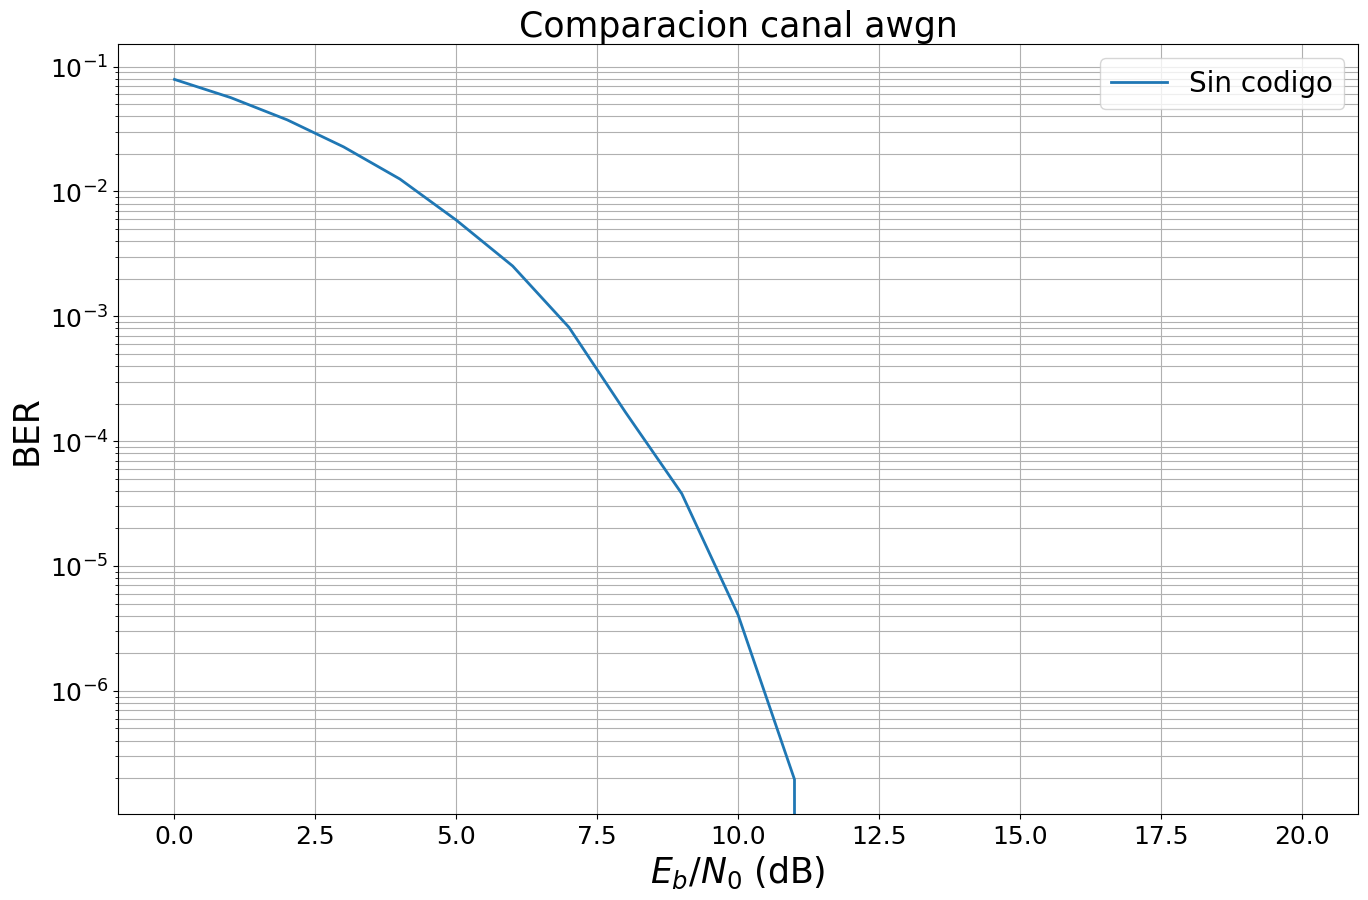

In [7]:
# Simulación y ploteo de BER sin codigo de canal

ber_plots = sionna.phy.utils.PlotBER(f"Comparacion canal {canal}")
ber_plots.simulate(sin_codigo,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

#### Generación Monte Carlo de Bits Congelados

**Objetivo**: Determinar qué $N-K$ bits deben congelarse (fijarse a 0) en el codificador Polar para **maximizar el desempeño BER**.

##### Metodología
Para cada bit-canal $i \in \{0, 1, \ldots, N-1\}$:

1. **Codificacion por bit-canal**: 1 bit de información en posición $i$, resto congelado
2. **Simulación**: $\text{lote\_mc} \times \text{num\_iter}$ transmisiones independientes generan las estadísticas
3. **Métrica de BER**: $\text{BER}_i = \frac{\text{errores}_i}{\text{total\_bits}_i}$

##### Selección de Bits Congelados
$$\mathcal{F} = \{i \mid \text{BER}_i \in \text{Top}(N-K)\}$$

Los bits con **mayor BER** se congelan porque son los canales más ruidosos. Los $K$ mejores canales transportan información.

**Fundamento teórico**: El método de construcción Polar basado en Monte Carlo aproxima el proceso de polarización del canal, donde los bits de menor capacidad $I(W_i)$ se congelan.

**Aceleración**: Compilación XLA (`@tf.function(jit_compile=True)`) para ejecución eficiente en GPU.

In [ ]:
# Generador Monte Carlo de bits congelados

# Estimador de BER por bit-canal usando Monte Carlo
BER_bits = np.zeros(N)

for i in range(N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y genera el codificador/decodificador temporal (1 bit de informacion)
    bits_congelados = np.array([j for j in range(N) if j != i]) # se analiza cada bit-canal
    codificador_temp = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador_temp = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1) # decodificador SCL con lista 1 (SC)

    # Simulacion del sistema por batch_size
    @tf.function(jit_compile=True)
    def simulacion_batch_size(batch_size_tf):
        # Bloques de transmision
        bits = datos([batch_size_tf, 1]) # solo 1 bit de datos por bit-canal
        bits_codif = codificador_temp(bits) # codifica a N bits
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal (solo 1 bit de datos por bit-canal)
        if canal == "awgn":
            y, h, no = canalAWGN(snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
        elif canal == "rayleigh":
            y, h, no = canalRayleigh(bloq_coher, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
        elif canal == "rice":
            y, h, no = canalRice(bloq_coher, k_factor_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
        elif canal == "lognormal":
            y, h, no = canalLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
        elif canal == "suzuki":
            y, h, no = canalRayleighLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        bits_decodif = decodificador_temp(llr)

        # Cálculo de errores
        err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
        
        return tf.cast(err, tf.int64), tf.constant(batch_size_tf, dtype=tf.int64)

    # Inicializa contadores de errores y bits
    errores_totales = 0
    bits_totales = 0
    lote_tf = tf.constant(lote_mc, dtype=tf.int32)

    # Se itera num_iter veces para acumular errores
    for b in range(num_iter):
        err, total = simulacion_batch_size(lote_tf)
        errores_totales += int(err.numpy()) # acumula errores
        bits_totales += int(total.numpy())

    BER_bits[i] = errores_totales / bits_totales # calcula BER para el bit-canal i
    print(f"| BER: {BER_bits[i]:.2e}")

    # Libera memoria
    del simulacion_batch_size
    del codificador_temp
    del decodificador_temp
    tf.keras.backend.clear_session()
    gc.collect()

print("\nCálculo de Canales finalizado.")
# Selecciona los bits congelados como los N-K bits con mayor BER
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

Procesando bit-canal 1/1024

/home/sergio/miniconda3/envs/sionna/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \
2026-01-30 22:09:55.902452: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %gather.29 = f32[896,1,2000,16]{3,2,1,0} gather(f32[1024,2000,16]{2,1,0} %broadcast.921, s64[896,1]{1,0} %constant.1755), offset_dims={1,2,3}, collapsed_slice_dims={}, start_index_map={0}, index_vector_dim=1, slice_sizes={1,2000,16}, metadata={op_type="GatherV2" op_name="GatherV2_34" source_file="/home/sergio/miniconda3/envs/sionna/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep const

| BER: 4.66e-01
Procesando bit-canal 2/1024| BER: 4.50e-01
Procesando bit-canal 3/1024| BER: 4.50e-01
Procesando bit-canal 4/1024

2026-01-30 22:11:20.385224: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 2s:

  %gather.29 = f32[896,1,2000,16]{3,2,1,0} gather(f32[1024,2000,16]{2,1,0} %broadcast.754, s64[896,1]{1,0} %constant.1534), offset_dims={1,2,3}, collapsed_slice_dims={}, start_index_map={0}, index_vector_dim=1, slice_sizes={1,2000,16}, metadata={op_type="GatherV2" op_name="GatherV2_34" source_file="/home/sergio/miniconda3/envs/sionna/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2026-01-30 22:11:20.836427: E external/loc

| BER: 4.30e-01
Procesando bit-canal 5/1024| BER: 4.50e-01
Procesando bit-canal 6/1024| BER: 4.30e-01
Procesando bit-canal 7/1024| BER: 4.30e-01
Procesando bit-canal 8/1024| BER: 4.02e-01
Procesando bit-canal 9/1024| BER: 4.51e-01
Procesando bit-canal 10/1024| BER: 4.30e-01
Procesando bit-canal 11/1024| BER: 4.30e-01
Procesando bit-canal 12/1024| BER: 4.01e-01
Procesando bit-canal 13/1024| BER: 4.30e-01
Procesando bit-canal 14/1024| BER: 4.02e-01
Procesando bit-canal 15/1024| BER: 4.01e-01
Procesando bit-canal 16/1024| BER: 3.62e-01
Procesando bit-canal 17/1024| BER: 4.51e-01
Procesando bit-canal 18/1024| BER: 4.30e-01
Procesando bit-canal 19/1024| BER: 4.30e-01
Procesando bit-canal 20/1024| BER: 4.01e-01
Procesando bit-canal 21/1024| BER: 4.30e-01
Procesando bit-canal 22/1024| BER: 4.02e-01
Procesando bit-canal 23/1024| BER: 4.01e-01
Procesando bit-canal 24/1024| BER: 3.63e-01
Procesando bit-canal 25/1024| BER: 4.30e-01
Procesando bit-canal 26/1024| BER: 4.02e-01
Procesando bit-canal 

#### Persistencia de Resultados BER

Guarda el vector $\text{BER}_{\text{bits}}$ en formato CSV para análisis posterior o reutilización.

**Convención de nomenclatura**:
```
YYMMDD_canal_ecualizador_SNR_BER_bits_N_K_numiter.csv
```

Esto evita re-ejecutar la simulación Monte Carlo (computacionalmente costosa).

In [ ]:
# Guardado variable BER_bits de la simulacion Monte Carlo

output_dir = f"results_{N}"
os.makedirs(output_dir, exist_ok=True)
fecha = datetime.now().strftime("%y%m%d")
df = pd.DataFrame({"BER bits": BER_bits})
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"{fecha}_{canal}_{ecualizador}_{snr_simulacion}SNR_BER_bits_{N}_{K}_{num_iter}iter.csv")
# OJO: Modificar arriba segun nombre de archivo deseado
df.to_csv(filename, index=True)

In [ ]:
# Recupero variable BER_bits de la simulacion Monte Carlo

output_dir = "results_128"
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"260122_rice_mmse_12.0SNR_BER_bits_128_64_1000iter.csv")
# OJO: Modificar arriba segun nombre de archivo deseado
df = pd.read_csv(filename)
BER_bits = df["BER bits"].to_numpy()
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

#### Sistema con Código Polar

Implementa la cadena completa con **código Polar** utilizando los bits congelados optimizados.

##### Codificación Polar
$$\mathbf{x} = \mathbf{u} \cdot G_N, \quad G_N = F^{\otimes n}, \quad F = \begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}$$

donde $\mathbf{u}$ contiene $K$ bits de información y $N-K$ bits congelados (ceros).

##### Decodificación SCL (Successive Cancellation List)
- **List size**: Mantiene $L$ hipótesis paralelas (complejidad $\mathcal{O}(LN\log N)$)
- **Ventaja vs SC**: Mejor desempeño en bloques cortos al explorar múltiples caminos

**Pipeline**:
$$\text{Bits}(K) \xrightarrow{\text{Polar}} \text{Coded}(N) \xrightarrow{\text{Interleaver}} \text{Canal} \xrightarrow{\text{Equalizer}} \text{Demapper} \xrightarrow{\text{SCL}} \hat{\text{Bits}}(K)$$

Tasa de código: $R = K/N$

In [ ]:
# Define el sistema de telecomunicaciones a simular, con código polar

class CodigoPolar(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bits_congelados, lista_SCL, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.polar_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.polar_decodif(llr)

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo Polar con los parametros generales y los bits congelados obtenidos

codigo_polar = CodigoPolar(canal, ecualizador, N, K, bits_congelados, list_scl, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo polar

# En caso de error de memoria, ejecute tf.keras.backend.clear_session()
ber_plots.simulate(codigo_polar,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

#### Codigo Polar con CRC

Hace uso de la funcionalidad de CRC para mejorar la decodificacion Polar tipo SCL. Se emplea CRC de 24 bits segun define la 3GPP para 5G NR.

In [ ]:
# Define el sistema de telecomunicaciones a simular, con Código Polar + CRC

class CodigoPolarCRC(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, crc_long, bits_congelados, lista_SCL, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.crc_long = crc_long
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL, crc_degree=crc_degree)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        K_efec = self.K - self.crc_long
        b = datos([batch_size, K_efec])
        b_crc = crc_codif(b)
        bits_codif = self.polar_codif(b_crc)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_crc = self.polar_decodif(llr)
        b_hat = b_crc[..., :K_efec] # elimina bits de CRC

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo Polar + CRC con los parametros generales y los bits congelados obtenidos

codigo_polar_crc = CodigoPolarCRC(canal, ecualizador, N, K, crc_long, bits_congelados, list_scl, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo Polar con CRC

# En caso de error de memoria, ejecute tf.keras.backend.clear_session()
ber_plots.simulate(codigo_polar_crc,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo Polar + CRC",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

#### Sistema con Código LDPC

Implementa la cadena completa con **código LDPC 5G NR** para comparación con Polar.

##### Código LDPC (Low-Density Parity-Check)
- **Matriz H**: Matriz de paridad dispersa ($\mathbf{H} \cdot \mathbf{c}^T = 0$)
- **Decodificación**: Algoritmo iterativo belief propagation (BP)
- **Estándar**: 3GPP 5G NR (38.212)

##### Ventajas LDPC
- Mejor desempeño en bloques largos y tasas altas
- Decodificación más simple que SCL
- Ampliamente adoptado en estándares (WiFi, 5G)

**Pipeline**:
$$\text{Bits}(K) \xrightarrow{\text{LDPC}} \text{Coded}(N) \xrightarrow{\text{Interleaver}} \text{Canal} \xrightarrow{\text{Equalizer}} \text{Demapper} \xrightarrow{\text{BP}} \hat{\text{Bits}}(K)$$

Esta celda permite **comparar Polar vs LDPC** bajo las mismas condiciones de canal.

In [ ]:
# Define el sistema de telecomunicaciones a simular, con código LDPC

class CodigoLDPC(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.ldpc_codif = sionna.phy.fec.ldpc.encoding.LDPC5GEncoder(self.K, self.N, self.bitsxsimb)
        self.ldpc_decodif = sionna.phy.fec.ldpc.decoding.LDPC5GDecoder(self.ldpc_codif)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.ldpc_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Bloques de recepcion
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.ldpc_decodif(llr)[0]

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo LDPC con los parametros generales

codigo_ldpc = CodigoLDPC(canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo LDPC

# En caso de error de memoria, ejecute tf.keras.backend.clear_session()
ber_plots.simulate(codigo_ldpc,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo LDPC",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);